# Importing Libraries and Loading Dataset

In [2]:
!pip install efficientnet_pytorch
!pip install torchmetrics
!pip install torchinfo
import torch
import torch.nn as nn
from torchvision import datasets
from torchsummary import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
import torchvision
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import flatten
import torch.optim as optim
import os
import time
import torchvision.transforms as transforms
import seaborn as sns
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Accuracy
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torchvision
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
transform = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

dataset = datasets.ImageFolder(root='combined_data_new',transform=transform)

# class_names = dataset.classes
# unique_folders = set()

# for image_path, label in dataset.samples:
#     folder_name = class_names[label]
#     unique_folders.add((folder_name, label))

# for folder_name, label in unique_folders:
#     print(f"Folder Name: {folder_name}, Label: {label}")

from torch.utils.data import random_split

dataset_len = [int(len(dataset) * 0.7), int(len(dataset) * 0.15)]
dataset_len.append(int(len(dataset) - sum(dataset_len)))
train_dataset, val_dataset, test_dataset = random_split(dataset, dataset_len)

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
def train_model(model, epochs_no, train_loader, test_loader, val_loader, optimizer, criterion, device):

    for epoch in range(epochs_no):

        train_pred = []
        vald_pred = []
        total_length = 0

        total_training_loss = 0.0
        model.train()
        for data in train_loader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            optimizer.zero_grad()
            model.to(device)
            outputs = model(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            train_pred.append(accuracy(Y_pred, target).item())
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            total_training_loss += loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_training_loss /= total_length

        total_length = 0

        model.eval()
        total_validation_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs, target = data
                inputs, target = inputs.to(device), target.to(device)
                model.to(device)
                outputs = model(inputs)
                Prob = nn.Softmax(dim=1)(outputs)
                Y_pred = Prob.argmax(1).int()
                vald_pred.append(accuracy(Y_pred, target).item())
                val_loss = criterion(outputs, target)
                total_validation_loss += val_loss.item()
                batch_length = target.size(0)
                total_length += batch_length
        total_validation_loss /= total_length

        training_acc_data.append(sum(train_pred) / len(train_pred))
        val_acc_data.append(sum(vald_pred) / len(vald_pred))

        training_loss_data.append(total_training_loss)
        val_loss_data.append(total_validation_loss)

        print(f'Epoch: {epoch+1}, Loss: {total_training_loss}, val_loss: {total_validation_loss}, train_acc: {training_acc_data[-1]}, val_acc : {val_acc_data[-1]}')

    return training_loss_data, val_loss_data, training_acc_data, val_acc_data

# VGG13 Model

In [6]:
class VGG13(nn.Module):
    def __init__(self, num_classes=55):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        test_tensor = torch.randn(1, 3, 40, 40)
        with torch.no_grad():
            features_output = self.features(test_tensor)
            conv_output_size = features_output.view(features_output.size(0), -1).size(1)

        self.classifier = nn.Sequential(
            nn.Linear(conv_output_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
accuracy = Accuracy(task = "multiclass", num_classes=55).to(device)

training_loss_data = []
val_loss_data = []
training_acc_data = []
val_acc_data = []

num_classes = 55

vgg = VGG13(num_classes=55).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(),lr=1e-5, weight_decay = 1e-9)
epoch_no = 90

training_loss_data,val_loss_data,training_acc_data,val_acc_data = train_model(vgg,epoch_no,train_loader,test_loader,val_loader,optimizer,criterion,device)

Epoch: 1, Loss: 0.12150011774983838, val_loss: 0.11561792979785018, train_acc: 0.0931750541286809, val_acc : 0.09667566873961025
Epoch: 2, Loss: 0.11406135799504127, val_loss: 0.11281943092578997, train_acc: 0.09912743508106187, val_acc : 0.09667566873961025
Epoch: 3, Loss: 0.11110814247701237, val_loss: 0.10926569599427653, train_acc: 0.09949945889058567, val_acc : 0.09667566873961025
Epoch: 4, Loss: 0.10650318165341902, val_loss: 0.10034942294372719, train_acc: 0.12888933984296663, val_acc : 0.13937114199830425
Epoch: 5, Loss: 0.09485760710152591, val_loss: 0.08794264327783427, train_acc: 0.2040043290527094, val_acc : 0.2535686728854974
Epoch: 6, Loss: 0.08232729196771076, val_loss: 0.07747186581363029, train_acc: 0.29905641238604275, val_acc : 0.3360339506632752
Epoch: 7, Loss: 0.07586828720669786, val_loss: 0.07295321389292257, train_acc: 0.34738568731007125, val_acc : 0.3665766459372308
Epoch: 8, Loss: 0.07239621097411539, val_loss: 0.06989929773751402, train_acc: 0.36155641238604

In [8]:
start_time = time.time()

testing_loss_data = []
testing_acc_data = []
testing_pred = []
Y_test = []
predictions = []

total_testing_loss = 0
total_length = 0
vgg.to(device)
vgg.eval()

with torch.no_grad():
    for data in test_loader:
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        outputs = vgg(inputs)
        Prob = nn.Softmax(dim=1)(outputs)
        Y_pred = Prob.argmax(1).int()

        test_loss = criterion(outputs, target)
        total_testing_loss += test_loss.item()
        batch_length = target.size(0)
        total_length += batch_length

        acc = accuracy(Y_pred, target).item()
        testing_pred.append(acc)
        Y_test.append(target)
        predictions.append(Y_pred)

    average_testing_loss = total_testing_loss / total_length
    testing_loss_data.append(average_testing_loss)
    testing_acc_data.append(sum(testing_pred) / len(testing_pred))

Y_pred = torch.cat([p for p in predictions])
Y_test = torch.cat([t for t in Y_test])
Final_accuracy = accuracy(Y_pred, Y_test).item()
precision, recall, f1, support = precision_recall_fscore_support(Y_test.cpu(), Y_pred.cpu())
training_time = time.time() - start_time

print("Performance Metrics:")
print(f"Time to Train : {training_time} seconds")
print(f"Accuracy      : {Final_accuracy * 100:.2f} %")
print(f"Precision     : {precision}")
print(f"Recall        : {recall}")
print(f"F1 Score      : {f1}")

Performance Metrics:
Time to Train : 4.581313371658325 seconds
Accuracy      : 81.01 %
Precision     : [0.96875    0.92592593 0.96666667 0.87878788 0.66666667 0.2
 0.33333333 0.33333333 0.7037037  0.6        0.83333333 0.5
 0.13333333 0.93333333 0.28571429 0.         0.94230769 0.4
 0.69230769 0.73913043 0.875      0.96       0.97196262 0.92307692
 0.78125    0.94736842 0.8        0.33333333 0.88888889 0.66666667
 0.625      1.         0.83783784 0.87878788 0.97142857 0.9
 1.         0.86666667 0.86486486 0.94736842 0.83870968 0.34782609
 0.83870968 0.78947368 0.625      0.71428571 0.66666667 0.63636364
 0.         0.6875     0.875      0.77777778 0.         0.54545455]
Recall        : [0.88571429 0.92592593 0.90625    0.87878788 0.83333333 0.25
 0.25       0.33333333 0.7037037  0.9375     0.90909091 0.22727273
 0.22222222 0.7        0.22222222 0.         1.         0.5
 0.81818182 0.65384615 0.93333333 0.88888889 0.93693694 0.92307692
 0.92592593 0.92307692 0.8        0.66666667 1.   

/user/kishoren/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
print("Accuracy and Loss values:")
print()
print(f"Training Accuracy : {training_acc_data[-1]*100:.2f} %")
print(f"Validation Accuracy : {val_acc_data[-1]*100:.2f} %")
print(f"Testing Accuracy : {testing_acc_data[-1]*100:.2f} %")
print()
print(f"Training Loss : {(sum(training_loss_data)/len(training_loss_data))}")
print(f"Validation Loss : {(sum(val_loss_data)/len(val_loss_data))}")
print(f"Testing Loss : {(sum(testing_loss_data)/len(testing_loss_data))}")

Accuracy and Loss values:

Training Accuracy : 87.35 %
Validation Accuracy : 80.77 %
Testing Accuracy : 81.04 %

Training Loss : 0.037866791109287326
Validation Loss : 0.04136828962689302
Testing Loss : 0.02075499392241136


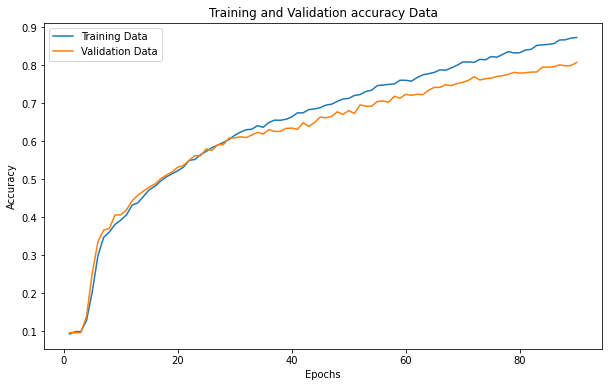

In [10]:
epochs = range(1,epoch_no+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_data, label='Training Data')
plt.plot(epochs, val_acc_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy Data')
plt.legend()
plt.show()

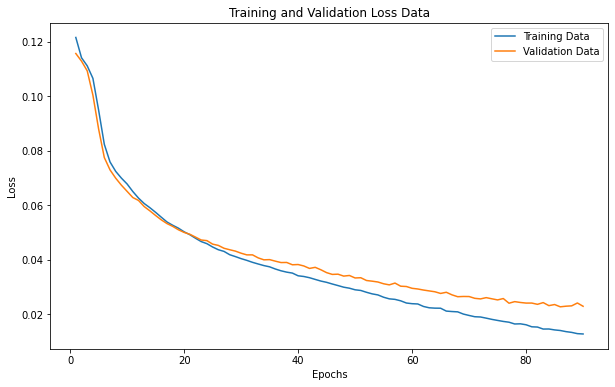

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_data, label='Training Data')
plt.plot(epochs, val_loss_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Data')
plt.legend()
plt.show()

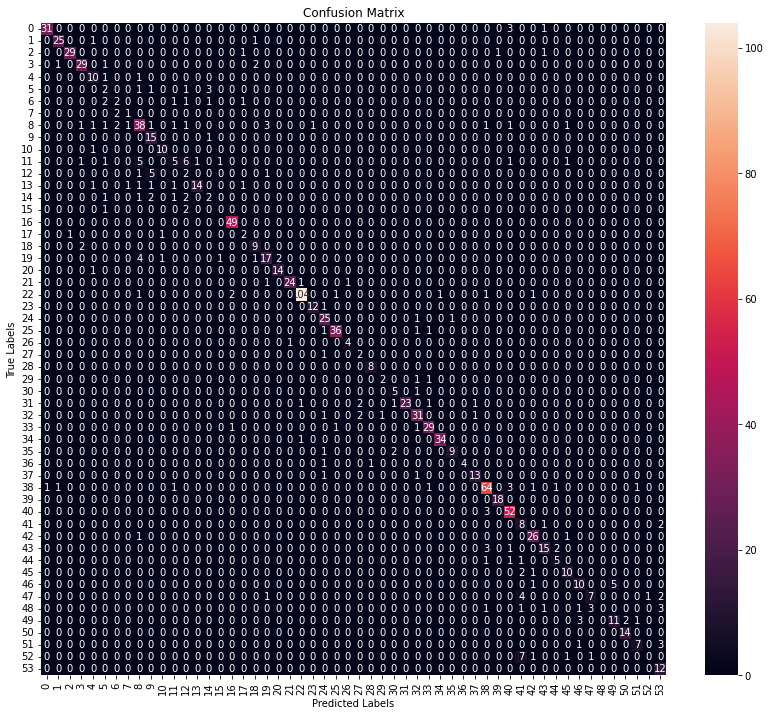

In [12]:
cmat = confusion_matrix(Y_test.cpu(), Y_pred.cpu())
plt.figure(figsize=(14, 12))
sns.heatmap(cmat, annot=True, fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
torch.save(vgg.state_dict(), "vgg.pth")

# ResNet34 Model

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNet34(nn.Module):
    def __init__(self, num_classes=55):
        super(ResNet34, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block2 = self._make_layer(64, 64, 3)
        self.block3 = self._make_layer(64, 128, 4, stride=2)
        self.block4 = self._make_layer(128, 256, 6, stride=2)
        self.block5 = self._make_layer(256, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [16]:
accuracy = Accuracy(task = "multiclass", num_classes=55).to(device)

training_loss_data = []
val_loss_data = []
training_acc_data = []
val_acc_data = []

num_classes = 55

resnet = ResNet34(num_classes=55).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-6, weight_decay=1e-9)
epoch_no = 32
training_loss_data,val_loss_data,training_acc_data,val_acc_data = train_model(resnet,epoch_no,train_loader,test_loader,val_loader,optimizer,criterion,device)

Epoch: 1, Loss: 0.12633819793786655, val_loss: 0.12244523351049048, train_acc: 0.03701636904761905, val_acc : 0.06108539096183247
Epoch: 2, Loss: 0.11639212444494196, val_loss: 0.1146016831801264, train_acc: 0.12254802492402848, val_acc : 0.1449009771976206
Epoch: 3, Loss: 0.10717829184260577, val_loss: 0.10679520725060673, train_acc: 0.22093141238604272, val_acc : 0.22492283955216408
Epoch: 4, Loss: 0.09874797406094192, val_loss: 0.09995785773891724, train_acc: 0.29570819810032845, val_acc : 0.27250514386428726
Epoch: 5, Loss: 0.09095775268547564, val_loss: 0.09365171812468231, train_acc: 0.35888460491384777, val_acc : 0.3065200617743863
Epoch: 6, Loss: 0.08424851037318411, val_loss: 0.08840909706787535, train_acc: 0.40745062239113305, val_acc : 0.35458461940288544
Epoch: 7, Loss: 0.07805300998865834, val_loss: 0.08365318935231322, train_acc: 0.45393668824718114, val_acc : 0.3823623971806632
Epoch: 8, Loss: 0.07259326913888826, val_loss: 0.07933975762664076, train_acc: 0.4989515691995

In [17]:
start_time = time.time()

testing_loss_data = []
testing_acc_data = []
testing_pred = []
Y_test = []
predictions = []

total_testing_loss = 0
total_length = 0
resnet.to(device)
resnet.eval()

with torch.no_grad():
    for data in test_loader:
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        outputs = resnet(inputs)
        Prob = nn.Softmax(dim=1)(outputs)
        Y_pred = Prob.argmax(1).int()

        test_loss = criterion(outputs, target)
        total_testing_loss += test_loss.item()
        batch_length = target.size(0)
        total_length += batch_length

        acc = accuracy(Y_pred, target).item()
        testing_pred.append(acc)
        Y_test.append(target)
        predictions.append(Y_pred)

    average_testing_loss = total_testing_loss / total_length
    testing_loss_data.append(average_testing_loss)
    testing_acc_data.append(sum(testing_pred) / len(testing_pred))

Y_pred = torch.cat([p for p in predictions])
Y_test = torch.cat([t for t in Y_test])
Final_accuracy = accuracy(Y_pred, Y_test).item()
precision, recall, f1, support = precision_recall_fscore_support(Y_test.cpu(), Y_pred.cpu())
training_time = time.time() - start_time

print("Performance Metrics:")
print(f"Time to Train : {training_time} seconds")
print(f"Accuracy      : {Final_accuracy * 100:.2f} %")
print(f"Precision     : {precision}")
print(f"Recall        : {recall}")
print(f"F1 Score      : {f1}")

Performance Metrics:
Time to Train : 4.149202585220337 seconds
Accuracy      : 72.56 %
Precision     : [0.91891892 0.76666667 0.75       0.81578947 1.         0.
 0.         0.         0.53164557 0.75       0.75       0.38461538
 0.36363636 0.71428571 0.         0.         0.92       0.
 1.         0.85714286 0.63636364 0.86206897 0.80451128 1.
 0.76666667 0.78947368 0.         0.         1.         0.
 0.8        0.85714286 0.64285714 0.875      0.88888889 1.
 1.         0.84615385 0.87179487 0.7826087  0.87096774 0.36363636
 0.80645161 0.2962963  0.         0.         0.71428571 0.57142857
 0.         0.5        0.5        0.         0.         0.29166667]
Recall        : [0.97142857 0.85185185 0.9375     0.93939394 0.08333333 0.
 0.         0.         0.77777778 0.5625     0.81818182 0.45454545
 0.44444444 0.25       0.         0.         0.93877551 0.
 0.36363636 0.69230769 0.93333333 0.92592593 0.96396396 0.92307692
 0.85185185 0.76923077 0.         0.         0.125      0.
 0.666

/user/kishoren/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
print("Accuracy and Loss values:")
print()
print(f"Training Accuracy : {training_acc_data[-1]*100:.2f} %")
print(f"Validation Accuracy : {val_acc_data[-1]*100:.2f} %")
print(f"Testing Accuracy : {testing_acc_data[-1]*100:.2f} %")
print()
print(f"Training Loss : {(sum(training_loss_data)/len(training_loss_data))}")
print(f"Validation Loss : {(sum(val_loss_data)/len(val_loss_data))}")
print(f"Testing Loss : {(sum(testing_loss_data)/len(testing_loss_data))}")

Accuracy and Loss values:

Training Accuracy : 95.67 %
Validation Accuracy : 72.41 %
Testing Accuracy : 72.59 %

Training Loss : 0.050468595702823756
Validation Loss : 0.06346135264637685
Testing Loss : 0.03670324556503562


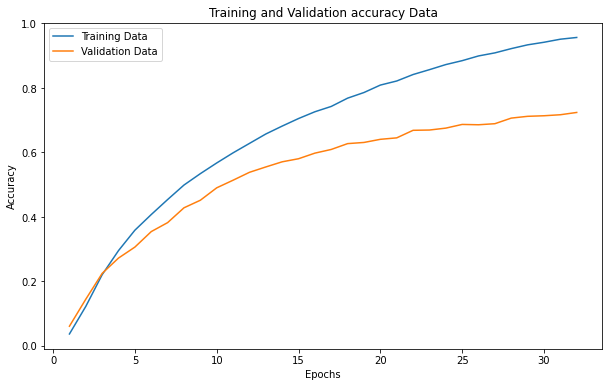

In [19]:
epochs = range(1,epoch_no+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_data, label='Training Data')
plt.plot(epochs, val_acc_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy Data')
plt.legend()
plt.show()

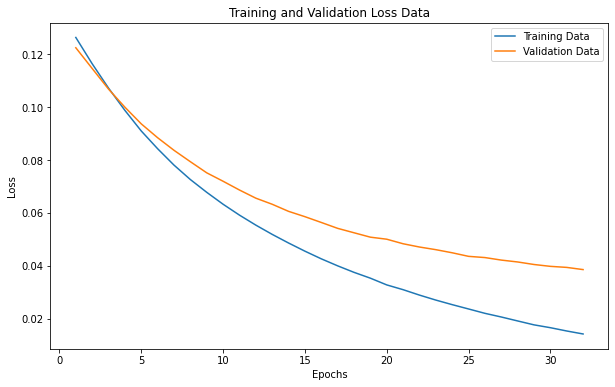

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_data, label='Training Data')
plt.plot(epochs, val_loss_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Data')
plt.legend()
plt.show()

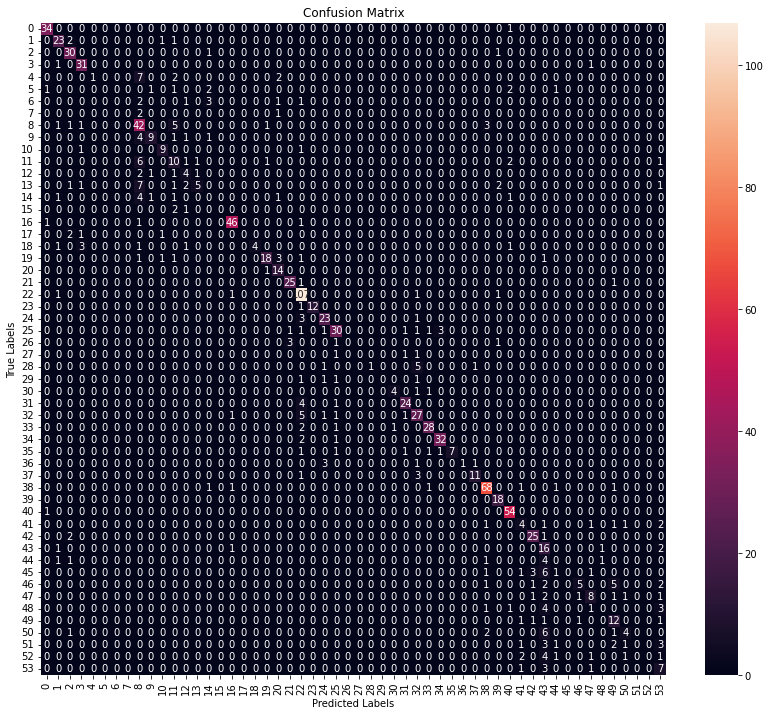

In [21]:
cmat = confusion_matrix(Y_test.cpu(), Y_pred.cpu())
plt.figure(figsize=(14, 12))
sns.heatmap(cmat, annot=True, fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
torch.save(resnet.state_dict(), "resnet.pth")

# Vision Image Transformer

In [23]:
class VisionTransformer_Model(nn.Module):
    def __init__(self, in_channels, img_size, num_classes, embedding_dim, num_attention_heads, patch_size, num_layers):
        super(VisionTransformer_Model, self).__init__()

        self.patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, embedding_dim , kernel_size=patch_size, stride=patch_size),
            nn.BatchNorm2d(embedding_dim),
            nn.Flatten(2)
        )

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_attention_heads), num_layers = num_layers
        )

        self.op = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.encoder(x)
        x = x.mean(dim=1)
        x = self.op(x)
        return x

In [24]:
in_channels = 3
img_size = 40
num_classes = 55
embedding_dim = 13 * 13
num_attention_heads = 13
patch_size = 3
num_layers = 12

vision_transformer = VisionTransformer_Model( in_channels, img_size, num_classes, embedding_dim, num_attention_heads, patch_size, num_layers)

In [25]:
accuracy = Accuracy(task = "multiclass", num_classes=55).to(device)

training_loss_data = []
val_loss_data = []
training_acc_data = []
val_acc_data = []

num_classes = 55

vision_transformer = vision_transformer.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vision_transformer.parameters(),lr=1e-5, weight_decay = 1e-9)
epoch_no = 30

training_loss_data,val_loss_data,training_acc_data,val_acc_data = train_model(vision_transformer,epoch_no,train_loader,test_loader,val_loader,optimizer,criterion,device)

Epoch: 1, Loss: 0.11750481682999127, val_loss: 0.11562087521307761, train_acc: 0.09484916127153806, val_acc : 0.09667566873961025
Epoch: 2, Loss: 0.11401803927595208, val_loss: 0.11099099323036574, train_acc: 0.11159023270010948, val_acc : 0.10622427985072136
Epoch: 3, Loss: 0.10348400459681349, val_loss: 0.09537815735874326, train_acc: 0.2525534361955665, val_acc : 0.34259259286854005
Epoch: 4, Loss: 0.08824139767779467, val_loss: 0.08206275347116831, train_acc: 0.4102746212766284, val_acc : 0.4651491766174634
Epoch: 5, Loss: 0.07682220835645659, val_loss: 0.07212989249225274, train_acc: 0.4950791396910236, val_acc : 0.539094650083118
Epoch: 6, Loss: 0.06802126706815233, val_loss: 0.06432178982881848, train_acc: 0.5538589015957855, val_acc : 0.5764210389720069
Epoch: 7, Loss: 0.060944575978483025, val_loss: 0.05806397757742232, train_acc: 0.5964218072948002, val_acc : 0.6244855970144272
Epoch: 8, Loss: 0.0551099553272949, val_loss: 0.05296456346121059, train_acc: 0.6306479977709907, v

In [26]:
start_time = time.time()

testing_loss_data = []
testing_acc_data = []
testing_pred = []
Y_test = []
predictions = []

total_testing_loss = 0
total_length = 0
vision_transformer.to(device)
vision_transformer.eval()

with torch.no_grad():
    for data in test_loader:
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        outputs = vision_transformer(inputs)
        Prob = nn.Softmax(dim=1)(outputs)
        Y_pred = Prob.argmax(1).int()

        test_loss = criterion(outputs, target)
        total_testing_loss += test_loss.item()
        batch_length = target.size(0)
        total_length += batch_length

        acc = accuracy(Y_pred, target).item()
        testing_pred.append(acc)
        Y_test.append(target)
        predictions.append(Y_pred)

    average_testing_loss = total_testing_loss / total_length
    testing_loss_data.append(average_testing_loss)
    testing_acc_data.append(sum(testing_pred) / len(testing_pred))

Y_pred = torch.cat([p for p in predictions])
Y_test = torch.cat([t for t in Y_test])
Final_accuracy = accuracy(Y_pred, Y_test).item()
precision, recall, f1, support = precision_recall_fscore_support(Y_test.cpu(), Y_pred.cpu())
training_time = time.time() - start_time

print("Performance Metrics:")
print(f"Time to Train : {training_time} seconds")
print(f"Accuracy      : {Final_accuracy * 100:.2f} %")
print(f"Precision     : {precision}")
print(f"Recall        : {recall}")
print(f"F1 Score      : {f1}")

Performance Metrics:
Time to Train : 5.492368459701538 seconds
Accuracy      : 89.29 %
Precision     : [0.97222222 0.96428571 0.96875    0.94285714 0.85714286 0.63636364
 1.         1.         0.83050847 0.88888889 1.         0.94444444
 0.61538462 0.94736842 0.5        0.         0.98       1.
 1.         0.95652174 0.88235294 0.86666667 0.92372881 1.
 0.89285714 0.94444444 1.         1.         0.8        1.
 0.83333333 0.96666667 0.85       0.81081081 0.97222222 1.
 0.5        1.         0.91780822 1.         0.94827586 0.54545455
 0.85185185 0.70833333 0.5        0.77777778 0.9375     0.72222222
 0.33333333 0.8        0.92857143 0.83333333 0.83333333 0.8       ]
Recall        : [1.         1.         0.96875    1.         0.5        0.875
 0.625      0.33333333 0.90740741 1.         1.         0.77272727
 0.88888889 0.9        0.22222222 0.         1.         1.
 1.         0.84615385 1.         0.96296296 0.98198198 0.92307692
 0.92592593 0.87179487 0.6        0.33333333 1.       

In [27]:
print("Accuracy and Loss values:")
print()
print(f"Training Accuracy : {training_acc_data[-1]*100:.2f} %")
print(f"Validation Accuracy : {val_acc_data[-1]*100:.2f} %")
print(f"Testing Accuracy : {testing_acc_data[-1]*100:.2f} %")
print()
print(f"Training Loss : {(sum(training_loss_data)/len(training_loss_data))}")
print(f"Validation Loss : {(sum(val_loss_data)/len(val_loss_data))}")
print(f"Testing Loss : {(sum(testing_loss_data)/len(testing_loss_data))}")

Accuracy and Loss values:

Training Accuracy : 95.11 %
Validation Accuracy : 87.10 %
Testing Accuracy : 89.30 %

Training Loss : 0.04205652087620772
Validation Loss : 0.04314945886792294
Testing Loss : 0.016550707251145033


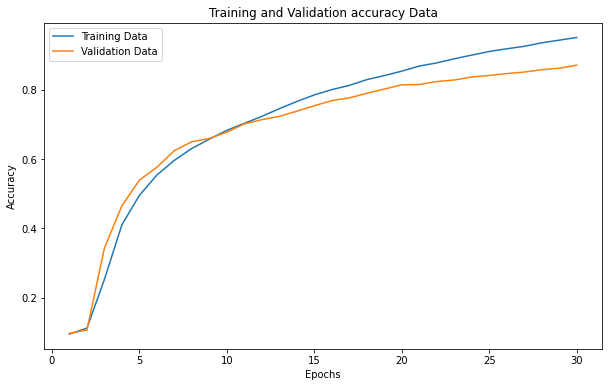

In [28]:
epochs = range(1,epoch_no+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_data, label='Training Data')
plt.plot(epochs, val_acc_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy Data')
plt.legend()
plt.show()

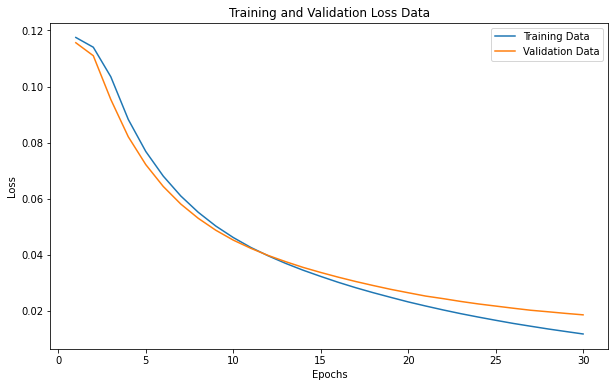

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_data, label='Training Data')
plt.plot(epochs, val_loss_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Data')
plt.legend()
plt.show()

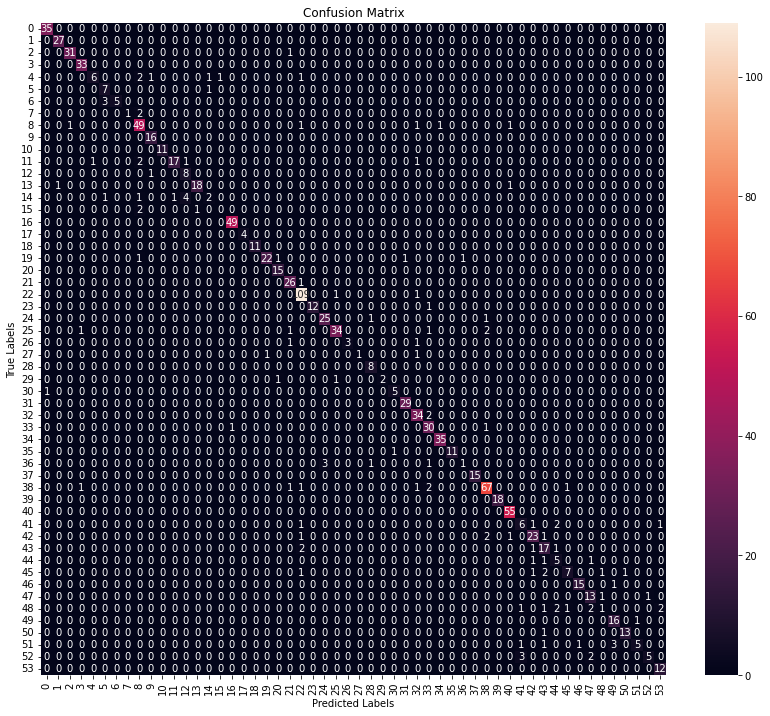

In [30]:
cmat = confusion_matrix(Y_test.cpu(), Y_pred.cpu())
plt.figure(figsize=(14, 12))
sns.heatmap(cmat, annot=True, fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
torch.save(vision_transformer.state_dict(), "vit.pth")